# Load data

In [1]:
import xarray as xr

data_dir = 'D:/VScode/Last_deglaciation/data'
ds_sat_EOFs = xr.open_dataset(data_dir + '/ds_sat_EOFs.nc')
# ds_sat_EOFs.info

sat_centered_weighted = ds_sat_EOFs['sat_centered_weighted'].values
sat_centered_weighted = sat_centered_weighted.reshape(len(ds_sat_EOFs['age']), 96*144)
print('shape of the reshaped sat_centered_weighted:', sat_centered_weighted.shape)



ds_seaice = xr.open_dataset('D:/VScode/Last_deglaciation/data/ds_seaice.nc')
sic_centered_weighted = ds_seaice['sic_centered_weighted'].values
sic_centered_weighted = sic_centered_weighted.reshape(len(ds_seaice['age']), 96*144)

print('shape of the reshaped sic_centered_weighted:', sic_centered_weighted.shape)

shape of the reshaped sat_centered_weighted: (65, 13824)
shape of the reshaped sic_centered_weighted: (65, 13824)


# Doing CCA, only for the area of the Southern Ocean class

## The lat lon pairs are generated in notebook 'LGME_SEAICE_ana.ipynb'

In [2]:
# load the lat_lon_pairs
import numpy as np
path='D:/VScode/Last_deglaciation/data/lat_lon_pairs.npy'
lat_lon_pairs=np.load(path, allow_pickle=True)
lat_lon_pairs

array([[-78.63158 , 182.5     ],
       [-76.73684 , 165.      ],
       [-76.73684 , 167.5     ],
       ...,
       [ 72.947365, 117.5     ],
       [ 72.947365, 120.      ],
       [ 72.947365, 125.      ]], dtype=float32)

# Check data

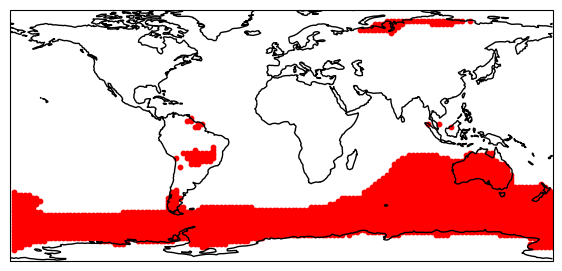

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Separate latitudes and longitudes from the pairs
lats, lons = zip(*lat_lon_pairs)

# Create a figure and axis with a global map projection
fig, ax = plt.subplots(figsize=(7, 3.5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.COASTLINE)

# Plot the lat-lon pairs as red dots
ax.scatter(lons, lats, color='red', s=10, transform=ccrs.PlateCarree())

# Display the plot
plt.show()


# Extract sat and sic data in this region

In [4]:
import numpy as np
import xarray as xr

def extract_data(ds, variable,lat_lon_pairs):
    # Initialize a list to store the sic data
    data_list = []
    
    # Loop through each lat-lon pair to extract the sic data
    for lat, lon in lat_lon_pairs:
        # Find the integer index corresponding to the lat and lon values
        lat_idx = np.argmin(np.abs(ds['lat'].values - lat))
        lon_idx = np.argmin(np.abs(ds['lon'].values - lon))
        
        # Extract sic data for dims=0 and age[:] for the current lat-lon pair
        # using integer-based indexing
        if variable=='sic':
            data = ds[variable].isel(dims=1,lat=lat_idx, lon=lon_idx).values
        if variable=='sat':
            data = ds[variable].isel(lat=lat_idx, lon=lon_idx).values
        
        # Append this data to our list
        data_list.append(data)
        
    # Convert list to a NumPy array for convenience
    data_array = np.array(data_list)
    
    return data_array


In [5]:
sat_SO_data = extract_data(ds_sat_EOFs, 'sat', lat_lon_pairs)
sic_SO_data = extract_data(ds_seaice, 'sic', lat_lon_pairs)

In [6]:
sat_SO_data.shape

(2451, 65)

# Doing CCA
ref: https://saturncloud.io/blog/canonical-correlation-analysis-in-python-with-sklearn/\
https://cmdlinetips.com/2020/12/canonical-correlation-analysis-in-python/\
https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html
https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

In [7]:
sat_SO_data.T.shape

(65, 2451)

In [8]:
from sklearn.cross_decomposition import CCA
cca = CCA(scale=False,n_components=2)
# cca.fit(sat_SO_data.T, sic_SO_data.T)
U,V=cca.fit_transform(sat_SO_data.T, sic_SO_data.T)
print(U.shape)
print(V.shape)

(65, 2)
(65, 2)


In [9]:
print('Corrcoef between U1 and V1',np.corrcoef(U[:, 0], V[:, 0]))
print('Corrcoef between U1 and V1',np.corrcoef(U[:, 1], V[:, 1]))

Corrcoef between U1 and V1 [[1. 1.]
 [1. 1.]]
Corrcoef between U1 and V1 [[1. 1.]
 [1. 1.]]


# Plot U and V

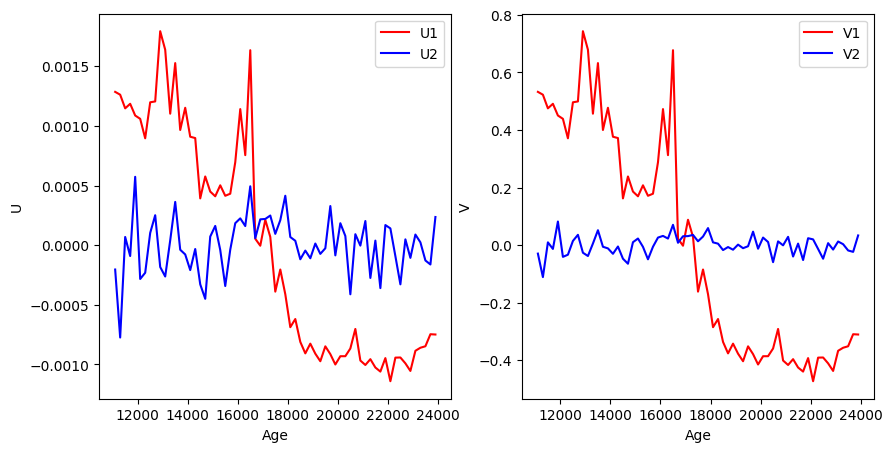

In [20]:
# plot U1 and U2
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ds_sat_EOFs['age'].values,U[:, 0], color='red', label='U1')
plt.plot(ds_sat_EOFs['age'].values,U[:, 1], color='blue', label='U2')
plt.xlabel('Age')
plt.ylabel('U')
plt.legend()

# plot V1 and V2
plt.subplot(1,2,2)
plt.plot(ds_sat_EOFs['age'].values,V[:, 0], color='red', label='V1')
plt.plot(ds_sat_EOFs['age'].values,V[:, 1], color='blue', label='V2')
plt.xlabel('Age')
plt.ylabel('V')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


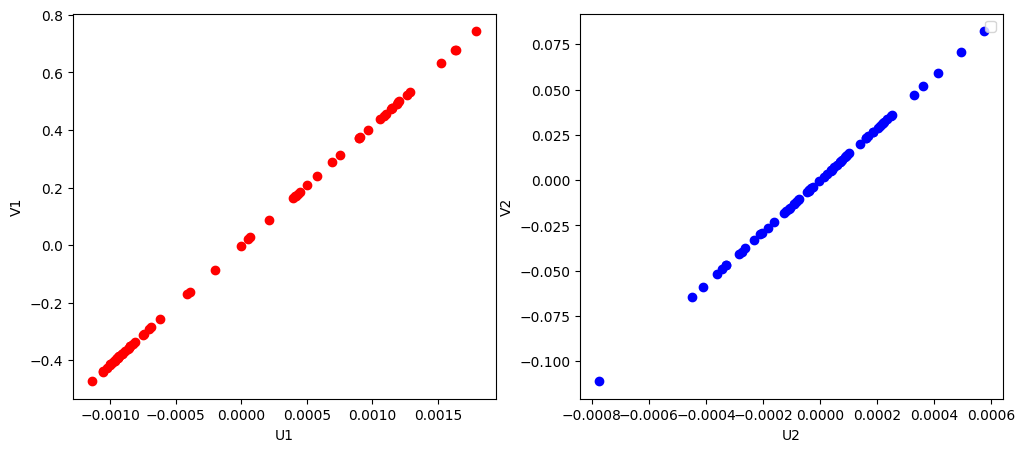

In [19]:
# plot canonical variates

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(U[:, 0], V[:, 0], color='red')
plt.xlabel('U1')
plt.ylabel('V1')

plt.subplot(1,2,2)
plt.scatter(U[:, 1], V[:, 1], color='blue')
plt.xlabel('U2')
plt.ylabel('V2')
plt.legend()


# Calculate loading

In [14]:
loading_SO_sat=cca.x_loadings_
loading_SO_sic=cca.y_loadings_

loading_SO_sat1=loading_SO_sat[:, 0] 
loading_SO_sat2=loading_SO_sat[:, 1]
loading_SO_sic1=loading_SO_sic[:, 0]
loading_SO_sic2=loading_SO_sic[:, 1]

In [61]:
loading_SO_sat.shape

(2451, 2)

In [62]:
sat_SO_data.T.shape

(65, 2451)

# Calculate loading*data to verify

(65, 2)


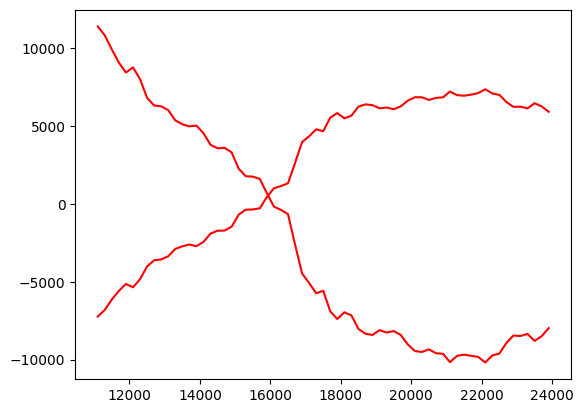

In [25]:
U_ver=sat_SO_data.T.dot(loading_SO_sat)
print(U_ver.shape)
# plot U_Ver
plt.figure()
plt.plot(ds_sat_EOFs['age'].values,U_ver, color='red', label='U_ver')


# Plot loading

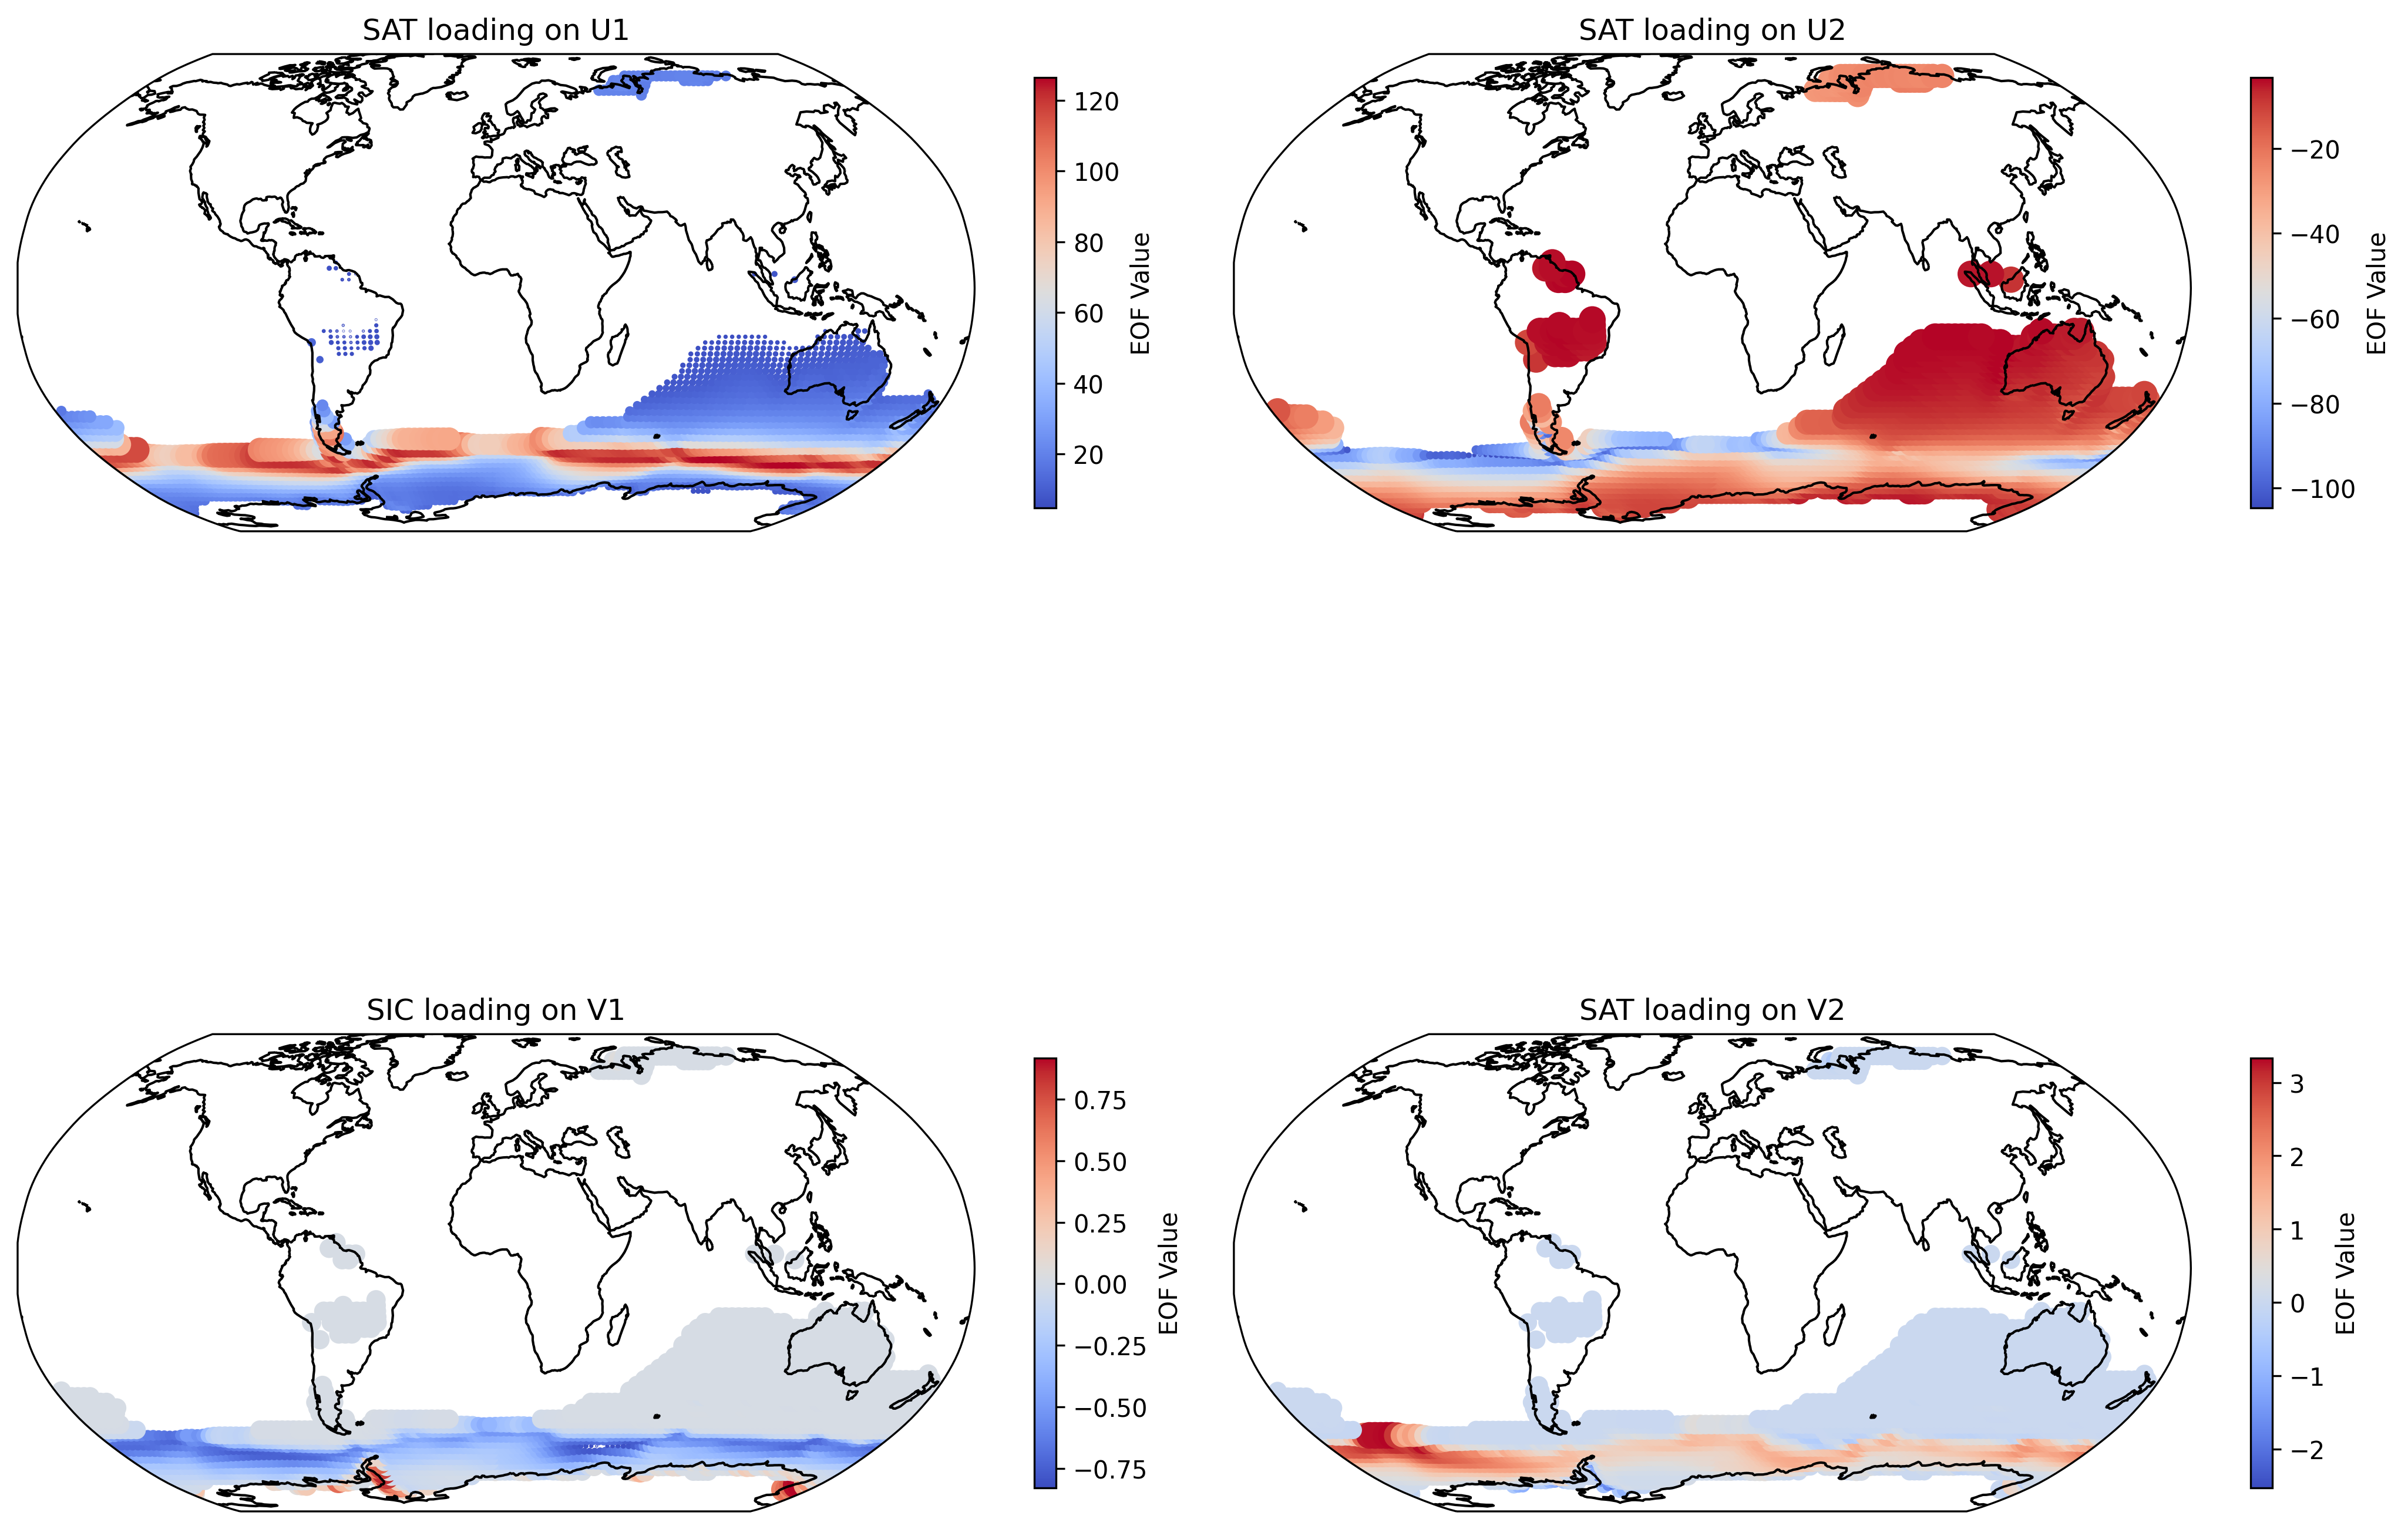

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Separate latitudes and longitudes from the pairs
lats, lons = zip(*lat_lon_pairs)

# List of EOFs to plot
eofs_list = [loading_SO_sat1, loading_SO_sat2, loading_SO_sic1, loading_SO_sic2]
titles = ['SAT loading on U1', 'SAT loading on U2', 'SIC loading on V1', 'SAT loading on V2']
# Create a figure and axes with a global map projection
fig, axs = plt.subplots(2, 2, figsize=(14, 14), dpi=300, subplot_kw=dict(projection=ccrs.Robinson()))

for i, ax in enumerate(axs.ravel()):
    eof = eofs_list[i]
    title = titles[i]

    # Normalizing the EOF values for size. This could be adapted per subplot if needed.
    eof_sizes = (eof - eof.min()) / (eof.max() - eof.min()) * 100

    ax.add_feature(cfeature.COASTLINE)
    scatter = ax.scatter(lons, lats, c=eof, s=eof_sizes, transform=ccrs.PlateCarree(), cmap='coolwarm')
    
    # Add a colorbar to each subplot
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05, shrink=0.3)
    cbar.ax.set_ylabel('EOF Value')
    
    ax.set_title(title)

# Adjust the layout
fig.tight_layout()
plt.show()
